In [ ]:
import pandas as pd
import glob
import os
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Behavior Data Preprocessing

In [ ]:
all_csv_files = glob.glob(os.path.join('yourpath', "*.csv"))

df_list = []

for filename in all_csv_files:
    # Struggling
    df = pd.read_csv(filename)
    basename = os.path.basename(filename)
    name_without_ext = os.path.splitext(basename)[0]

    if name_without_ext.startswith('Calming'):
        df['condition'] = 'Calming'
        df['subject_id'] = name_without_ext.replace('Calming', '')
    elif name_without_ext.startswith('Vexing'):
        df['condition'] = 'Vexing'
        df['subject_id'] = name_without_ext.replace('Vexing', '')

    df_list.append(df)

behavior_df = pd.concat(df_list, ignore_index=True)
print(behavior_df.head())

   TrialNumber                                             n_back  \
0            1  One Back Task \n\n Press TARGET if current let...   
1            1  One Back Task \n\n Press TARGET if current let...   
2            1  One Back Task \n\n Press TARGET if current let...   
3            1  One Back Task \n\n Press TARGET if current let...   
4            1  One Back Task \n\n Press TARGET if current let...   

  Stimulus_Letter  Response_Time  Correct_Response  Response condition  \
0               L            0.0               3.0       NaN   Calming   
1               A          487.0               3.0       3.0   Calming   
2               E          222.0               3.0       3.0   Calming   
3               E          189.0               4.0       4.0   Calming   
4               E           74.0               4.0       4.0   Calming   

  subject_id  
0  Subject11  
1  Subject11  
2  Subject11  
3  Subject11  
4  Subject11  


In [ ]:
# behavior_df.to_csv("Behavioral_data.csv")

In [ ]:
if 'behavior_df' in locals():

    behavior_df['BlockNumber'] = behavior_df['TrialNumber'].ffill()

    behavior_df['TrialInBlock'] = behavior_df.groupby(
        ['subject_id', 'condition', 'BlockNumber']
    ).cumcount() + 1

    print("\n--- DataFrame with new BlockNumber and TrialInBlock columns ---")

    print(behavior_df[[
        'subject_id',
        'condition',
        'TrialNumber',
        'BlockNumber',
        'TrialInBlock',
        'Response_Time'
    ]].head(24))

else:
    print("Error: 'behavior_df' not found. Please run the concatenation code first.")


--- DataFrame with new BlockNumber and TrialInBlock columns ---
   subject_id condition  TrialNumber  BlockNumber  TrialInBlock  Response_Time
0   Subject11   Calming            1            1             1            0.0
1   Subject11   Calming            1            1             2          487.0
2   Subject11   Calming            1            1             3          222.0
3   Subject11   Calming            1            1             4          189.0
4   Subject11   Calming            1            1             5           74.0
5   Subject11   Calming            1            1             6          417.0
6   Subject11   Calming            1            1             7          464.0
7   Subject11   Calming            1            1             8            0.0
8   Subject11   Calming            1            1             9          785.0
9   Subject11   Calming            1            1            10          477.0
10  Subject11   Calming            1            1            11   

In [ ]:
print(behavior_df["n_back"].unique())

['One Back Task \\n\\n Press TARGET if current letter is same as the previous letter\\n\\n'
 'Three Back Task \\n\\n Press TARGET if current letter is same as the third previous letter\\n\\n'
 'Rest']


In [ ]:
n_back_mapping = {
    'One Back Task \\n\\n Press TARGET if current letter is same as the previous letter\\n\\n': 'one_back',
    'Three Back Task \\n\\n Press TARGET if current letter is same as the third previous letter\\n\\n': 'three_back',
    'Rest': 'rest'
}

behavior_df['n_back'] = behavior_df['n_back'].map(n_back_mapping)

print("--- Cleaned 'n_back' column unique values ---")
print(behavior_df['n_back'].unique())

--- Cleaned 'n_back' column unique values ---
['one_back' 'three_back' 'rest']


In [ ]:
import pandas as pd

# 1. Remove 'rest' rows (This effectively removes Block 9)
behavior_df = behavior_df[behavior_df['n_back'] != 'rest'].copy()

# 2. APPLY YOUR FIX: Shift blocks 10+ down by 1
# This turns Block 10 -> 9, Block 11 -> 10, ... Block 17 -> 16
behavior_df.loc[behavior_df['BlockNumber'] > 9, 'BlockNumber'] -= 1

In [ ]:
print(behavior_df.isnull().sum())

TrialNumber           0
n_back                0
Stimulus_Letter       0
Response_Time         0
Correct_Response      0
Response            502
condition             0
subject_id            0
BlockNumber           0
TrialInBlock          0
dtype: int64


In [ ]:
import numpy as np
import pandas as pd

behavior_df['Correct_Response'] = pd.to_numeric(
    behavior_df['Correct_Response'],
    errors='coerce'
)

behavior_df['Subject_Response_Cleaned'] = pd.to_numeric(
    behavior_df['Response'],
    errors='coerce'
)

behavior_df['Response_Time'] = pd.to_numeric(
    behavior_df['Response_Time'],
    errors='coerce'
).fillna(0)


cond_unknown_target = behavior_df['Correct_Response'].isna()

cond_correct_hit = (behavior_df['Response_Time'] > 0) & \
                   (behavior_df['Correct_Response'] != 0) & \
                   (behavior_df['Subject_Response_Cleaned'] == behavior_df['Correct_Response'])

cond_correct_rejection = (behavior_df['Response_Time'] == 0) & \
                         (behavior_df['Correct_Response'] == 0)

cond_false_alarm = (behavior_df['Response_Time'] > 0) & \
                   (behavior_df['Correct_Response'] == 0)

cond_wrong_key = (behavior_df['Response_Time'] > 0) & \
                 (behavior_df['Correct_Response'] != 0) & \
                 (behavior_df['Subject_Response_Cleaned'] != behavior_df['Correct_Response'])

cond_miss_no_response = (behavior_df['Response_Time'] == 0) & \
                        (behavior_df['Correct_Response'] != 0)

conditions = [
    cond_unknown_target,
    cond_correct_hit | cond_correct_rejection,
    cond_false_alarm | cond_wrong_key,
    cond_miss_no_response
]
values = [0, 1, -1, 0]

behavior_df['Correct'] = np.select(conditions, values, default=0)

columns_to_drop = [
    'TrialNumber', 'Stimulus_Letter', 'Correct_Response',
    'Response', 'Subject_Response_Cleaned'
]
behavior_df = behavior_df.drop(columns=columns_to_drop)

print("\n--- 'Correct' column value counts ---")
print(behavior_df['Correct'].value_counts(dropna=False))


--- 'Correct' column value counts ---
Correct
 1    2554
 0     502
-1     464
Name: count, dtype: int64


In [ ]:
print(behavior_df.isnull().sum())

n_back           0
Response_Time    0
condition        0
subject_id       0
BlockNumber      0
TrialInBlock     0
Correct          0
dtype: int64


In [ ]:
behavior_df_vexing = behavior_df[behavior_df['condition'] == 'Vexing']
behavior_df_calming = behavior_df[behavior_df['condition'] == 'Calming']

In [ ]:
print(behavior_df_calming.head())

     n_back  Response_Time condition subject_id  BlockNumber  TrialInBlock  \
0  one_back            0.0   Calming  Subject11            1             1   
1  one_back          487.0   Calming  Subject11            1             2   
2  one_back          222.0   Calming  Subject11            1             3   
3  one_back          189.0   Calming  Subject11            1             4   
4  one_back           74.0   Calming  Subject11            1             5   

   Correct  
0        0  
1        1  
2        1  
3        1  
4        1  


## 2. Features Merging to Single Dataframe

### 2.1. Empatica

In [ ]:
# Path for Ahmed
empatica_path = r'E:\DM_Proj\data\Empatica Preprocessed' # The path for the folder An created, empatica preprocessed

In [ ]:
# Path for Owen
#empatica_path = os.path.join(opath, 'Empatica Preprocessed')

In [ ]:
# Path for An
#empatica_path = os.path.join(opath, 'Empatica Preprocessed')

In [ ]:
import pandas as pd
import glob
import os

all_empatica_files = glob.glob(os.path.join(empatica_path, "Empatica_Sub*.csv"))

empatica_list = []

for filename in all_empatica_files:

    df = pd.read_csv(filename)

    basename = os.path.basename(filename)
    name_without_ext = os.path.splitext(basename)[0]

    df['subject_id'] = name_without_ext.replace('Empatica_Sub', 'Subject')

    empatica_list.append(df)

if empatica_list:
    empatica_df = pd.concat(empatica_list, ignore_index=True)
    print(f"Successfully concatenated {len(all_empatica_files)} Empatica CSV files.")
    print(f"Shape of new Empatica data: {empatica_df.shape}")
else:
    print(f"No Empatica CSV files found in directory: {empatica_path}")

Successfully concatenated 5 Empatica CSV files.
Shape of new Empatica data: (3945, 15)


In [ ]:
print(empatica_df.columns)
print(behavior_df.columns)
empatica_df = empatica_df.fillna(empatica_df.mean(numeric_only=True))
print(empatica_df.isnull().sum())

Index(['Session', 'Block', 'Trial', 'BVP_mean', 'BVP_std', 'HR_mean', 'HR_std',
       'EDA_mean', 'EDA_std', 'TEMP_mean', 'IBI_mean', 'IBI_std', 'ACC_mean',
       'ACC_std', 'subject_id'],
      dtype='object')
Index(['n_back', 'Response_Time', 'condition', 'subject_id', 'BlockNumber',
       'TrialInBlock', 'Correct'],
      dtype='object')
Session       0
Block         0
Trial         0
BVP_mean      0
BVP_std       0
HR_mean       0
HR_std        0
EDA_mean      0
EDA_std       0
TEMP_mean     0
IBI_mean      0
IBI_std       0
ACC_mean      0
ACC_std       0
subject_id    0
dtype: int64


In [ ]:
print(empatica_df.head())

   Session    Block        Trial  BVP_mean    BVP_std  HR_mean    HR_std  \
0  Calming  Block 1  Instruction -0.210463  14.204292   78.434  0.138492   
1  Calming  Block 1      Resting -0.027295   4.606684   70.566  0.899138   
2  Calming  Block 1      Trial 1  2.092192   2.048130   78.775  0.077782   
3  Calming  Block 1     Trial 10  4.501548   7.756058   77.985  0.049497   
4  Calming  Block 1     Trial 11 -3.611190   4.400134   77.750  0.113137   

   EDA_mean   EDA_std  TEMP_mean  IBI_mean   IBI_std   ACC_mean    ACC_std  \
0  0.220553  0.001321     32.798  0.796911  0.000000  28.997630  16.320930   
1  0.218844  0.000577     32.792  0.914104  0.074119  45.471477   0.299251   
2  0.219270  0.000250     32.790  0.796911  0.000000  49.908369   0.070257   
3  0.219536  0.000059     32.820  0.929730  0.011049  56.835197   7.115435   
4  0.220605  0.000063     32.800  0.773473  0.055245  66.299181   6.433317   

  subject_id  
0  Subject11  
1  Subject11  
2  Subject11  
3  Subject11  

In [ ]:
import pandas as pd

# 1. Filter for rows that are either Instruction or Rest
special_rows = empatica_df[
    empatica_df['Trial'].isin(['Instruction', 'Resting']) |
    empatica_df['Block'].isin(['Instruction', 'Resting'])
].copy()

# 2. Group by Block and Trial to get the counts
counts = special_rows.groupby(['Block', 'Trial']).size()

print("--- Detailed Breakdown (All Rows) ---")
# .to_string() forces pandas to print every single row without hiding any
print(counts.to_string())

--- Detailed Breakdown (All Rows) ---
Block     Trial      
Block 1   Instruction     5
          Resting         5
Block 10  Instruction     5
          Resting         5
Block 11  Instruction     5
          Resting         5
Block 12  Instruction     5
          Resting         5
Block 13  Instruction     5
          Resting         5
Block 14  Instruction     5
          Resting         5
Block 15  Instruction     5
          Resting         5
Block 16  Instruction     5
          Resting         5
Block 17  Instruction     5
          Resting         5
Block 18  Instruction     5
          Resting         5
Block 19  Instruction     5
          Resting         5
Block 2   Instruction     5
          Resting         5
Block 20  Instruction     5
          Resting         5
Block 21  Instruction     5
          Resting         5
Block 22  Instruction     5
          Resting         5
Block 23  Instruction     5
          Resting         5
Block 24  Instruction     5
          Restin

In [ ]:
import pandas as pd

empatica_to_merge = empatica_df.copy()
# Filter out rows where 'TrialInBlock' is NaN or 'BlockNumber' is NaN
# This effectively removes 'Instruction' and 'Resting' trials as they don't have numeric trial numbers
# Also filter out the single row where Block is 'Resting' in empatica_to_merge which led to NaN in BlockNumber
empatica_to_merge_cleaned = empatica_to_merge[
    empatica_to_merge['Trial'].str.contains('Trial', na=False) &
    ~empatica_to_merge['Block'].str.contains('Resting', na=False)
].copy()

# Rename session to become condition
empatica_to_merge_cleaned = empatica_to_merge_cleaned.rename(columns={
    'Session': 'condition'})

# Ensure BlockNumber and TrialInBlock are numeric after filtering
empatica_to_merge_cleaned['BlockNumber'] = pd.to_numeric(
    empatica_to_merge_cleaned['Block'].str.replace('Block ', ''),
    errors='coerce'
)
empatica_to_merge_cleaned['TrialInBlock'] = pd.to_numeric(
    empatica_to_merge_cleaned['Trial'].str.replace('Trial ', ''),
    errors='coerce'
)

# Rename EDA columns to avoid conflicts and drop redundant 'condition' column
empatica_to_merge_cleaned = empatica_to_merge_cleaned.rename(columns={
    'EDA_mean': 'EDA_mean_empatica',
    'EDA_std': 'EDA_std_empatica'
})


# Separate the calming and vexing session from the cleaned data
empatica_to_merge_by_music = empatica_to_merge_cleaned.copy()
empatica_to_merge_calming = empatica_to_merge_by_music[empatica_to_merge_by_music['condition'] == 'Calming']
empatica_to_merge_vexing = empatica_to_merge_by_music[empatica_to_merge_by_music['condition'] == 'Vexing']

# Apply the block number adjustment for vexing sessions as before
empatica_to_merge_vexing.loc[:, "BlockNumber"] = empatica_to_merge_vexing["BlockNumber"] - 16

empatica_to_merge_calming = empatica_to_merge_calming.drop(columns=['condition', 'Block', 'Trial'])
empatica_to_merge_vexing = empatica_to_merge_vexing.drop(columns=['condition', 'Block', 'Trial'])

print(f"Shape of cleaned empatica_to_merge_calming: {empatica_to_merge_calming.shape}")
print(f"Shape of cleaned empatica_to_merge_vexing: {empatica_to_merge_vexing.shape}")

Shape of cleaned empatica_to_merge_calming: (1760, 14)


Shape of cleaned empatica_to_merge_vexing: (1760, 14)


In [ ]:
print(len(empatica_to_merge_vexing))
print(len(behavior_df_vexing))

print((empatica_to_merge_calming["BlockNumber"] == 17).sum())
print(len(behavior_df_calming))

# Behavioral data has some n_back = rest

1760
1760
0
1760


### 2.2 Biopac

In [ ]:
# Path for An
# biopac_path = os.path.join(opath, 'Biopac Preprocessed')

In [ ]:
# Path for Ahmed
biopac_path = r'E:\DM_Proj\data\Biopac Preprocessed'

In [ ]:
all_biopac_files = glob.glob(os.path.join(biopac_path, "Biopac_sub*.csv"))

biopac_list = []

for filename in all_biopac_files:

    df = pd.read_csv(filename)

    basename = os.path.basename(filename)
    name_without_ext = os.path.splitext(basename)[0]

    df['subject_id'] = name_without_ext.replace('Biopac_subject', 'Subject')[:-1]

    biopac_list.append(df)

if biopac_list:
    biopac_df = pd.concat(biopac_list, ignore_index=True)
    print(f"Successfully concatenated {len(all_biopac_files)} Biopac CSV files.")
    print(f"Shape of new Empatica data: {biopac_df.shape}")

else:
    print(f"No Biopac CSV files found in directory: {biopac_path}")

Successfully concatenated 5 Biopac CSV files.
Shape of new Empatica data: (3520, 17)


In [ ]:
print(biopac_df.isnull().sum())

block         0
trial         0
condition     0
task          0
EDA_mean      0
EDA_std       0
ECG_mean      0
ECG_std       0
EMG_mean      0
EMG_std       0
RESP_mean     0
RESP_std      0
PPG_mean      0
PPG_std       0
SKT_mean      0
SKT_std       0
subject_id    0
dtype: int64


In [ ]:
print(biopac_df.head())

   block  trial condition    task   EDA_mean   EDA_std  ECG_mean   ECG_std  \
0      1      1   calming  1_back   8.461767  0.246137  0.000247  0.239379   
1      1      2   calming  1_back   9.678561  0.550727  0.005498  0.250009   
2      1      3   calming  1_back  11.068950  0.252101  0.006715  0.236163   
3      1      4   calming  1_back  11.178923  0.227100  0.011875  0.245297   
4      1      5   calming  1_back  11.700157  0.196261  0.009592  0.239032   

   EMG_mean   EMG_std  RESP_mean  RESP_std  PPG_mean   PPG_std   SKT_mean  \
0 -0.002432  0.043036  -0.532722  0.121633  0.026957  0.152914  31.317968   
1 -0.002137  0.040612  -0.280047  0.227084  0.068932  0.104521  31.314135   
2 -0.002220  0.041671  -0.905325  0.284885  0.036222  0.121187  31.298011   
3 -0.001878  0.039436  -0.352025  0.259368  0.071970  0.109964  31.269257   
4 -0.002114  0.040577  -0.554071  0.322226  0.030408  0.126139  31.247711   

    SKT_std subject_id  
0  0.004747  Subject11  
1  0.002354  Subje

In [ ]:
import pandas as pd

# Copy biopac to merge
biopac_to_merge = biopac_df.copy()

# Rename 'trial' to 'TrialInBlock' and 'block' to 'BlockNumber'
biopac_to_merge = biopac_to_merge.rename(columns = {"trial": "TrialInBlock", "block": "BlockNumber"})
biopac_to_merge["BlockNumber"] = pd.to_numeric(biopac_to_merge["BlockNumber"], errors='coerce')
biopac_to_merge["TrialInBlock"] = pd.to_numeric(biopac_to_merge["TrialInBlock"], errors= 'coerce')

# Fixing mismatch in subject ID of subject 8
biopac_to_merge['subject_id'] = biopac_to_merge['subject_id'].replace('Subject_8', 'Subject8')

# Renaming EDA column to distinguish between biopac and empatica
biopac_to_merge = biopac_to_merge.rename(columns={
    'EDA_mean': 'EDA_mean_biopac',
    'EDA_std': 'EDA_std_biopac'
})

# Separate the calming and vexing session
biopac_to_merge_per_music = biopac_to_merge.copy()
biopac_to_merge_calming = biopac_to_merge_per_music[biopac_to_merge_per_music['condition'] == 'calming']
biopac_to_merge_vexing = biopac_to_merge_per_music[biopac_to_merge_per_music['condition'] == 'vexing']
biopac_to_merge_vexing.loc[:, "BlockNumber"] = biopac_to_merge_vexing["BlockNumber"] - 16

# Drop column condition
biopac_to_merge_calming = biopac_to_merge_calming.drop(columns=['condition'])
biopac_to_merge_vexing = biopac_to_merge_vexing.drop(columns=['condition'])

print("Unique subjects in biopac_to_merge_calming after correction:", biopac_to_merge_calming['subject_id'].unique())
print("Unique subjects in biopac_to_merge_vexing after correction:", biopac_to_merge_vexing['subject_id'].unique())

Unique subjects in biopac_to_merge_calming after correction: ['Subject11' 'Subject3' 'Subject4' 'Subject6' 'Subject8']
Unique subjects in biopac_to_merge_vexing after correction: ['Subject11' 'Subject3' 'Subject4' 'Subject6' 'Subject8']


### 2.4. Merge all data into 1 dataframe

In [ ]:
print(empatica_to_merge_calming["BlockNumber"].unique())
print(empatica_to_merge_vexing["BlockNumber"].unique())

print(biopac_to_merge_calming["BlockNumber"].unique())
print(biopac_to_merge_vexing["BlockNumber"].unique())

print(behavior_df_calming["BlockNumber"].unique())
print(behavior_df_vexing["BlockNumber"].unique())

print(len(behavior_df_vexing[behavior_df_vexing['BlockNumber'] == 17]))

[ 1 10 11 12 13 14 15 16  2  3  4  5  6  7  8  9]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0


#### 2.4.1 Dataframe for model predicting n-back tasks based on physiological and behavioral data

In [ ]:
# Merge based on session for Empatica and Behavior
merge_keys = ['subject_id', 'BlockNumber', 'TrialInBlock']

calming_df = pd.merge(
    behavior_df_calming, # This df has the 'condition' column we want to keep
    empatica_to_merge_calming, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
).merge(
    biopac_to_merge_calming, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
)

vexing_df = pd.merge(
    behavior_df_vexing, # This df has the 'condition' column we want to keep
    empatica_to_merge_vexing, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
).merge(
    biopac_to_merge_vexing, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
)

print("--- Merge Complete for Calming---")
print(f"Shape of original behavioral data: {behavior_df_calming.shape}")
print(f"Shape of final merged data:      {calming_df.shape}")

if len(behavior_df_calming) != len(calming_df):
    print("\nWarning: Row counts don't match. Some trials may not have")
    print("had a matching biometric record.")
else:
    print("\nSuccess! All behavioral trials were matched.")

print("\n--- Head of Final Merged DataFrame ---")
print(calming_df.head())

print("--- Merge Complete for Vexing---")
print(f"Shape of original behavioral data: {behavior_df_vexing.shape}")
print(f"Shape of final merged data:      {vexing_df.shape}")

if len(behavior_df_vexing) != len(vexing_df):
    print("\nWarning: Row counts don't match. Some trials may not have")
    print("had a matching biometric record.")
else:
    print("\nSuccess! All behavioral trials were matched.")

print("\n--- Head of Final Merged DataFrame ---")
print(vexing_df.head())

--- Merge Complete for Calming---
Shape of original behavioral data: (1760, 7)
Shape of final merged data:      (1760, 31)

Success! All behavioral trials were matched.

--- Head of Final Merged DataFrame ---
     n_back  Response_Time condition subject_id  BlockNumber  TrialInBlock  \
0  one_back            0.0   Calming  Subject11            1             1   
1  one_back          487.0   Calming  Subject11            1             2   
2  one_back          222.0   Calming  Subject11            1             3   
3  one_back          189.0   Calming  Subject11            1             4   
4  one_back           74.0   Calming  Subject11            1             5   

   Correct  BVP_mean   BVP_std  HR_mean  ...  ECG_mean   ECG_std  EMG_mean  \
0        0  2.092192  2.048130   78.775  ...  0.000247  0.239379 -0.002432   
1        1  2.683048  2.288534   78.915  ...  0.005498  0.250009 -0.002137   
2        1  1.500902  0.385945   78.775  ...  0.006715  0.236163 -0.002220   
3        1

In [ ]:
print(calming_df.columns.tolist())
print(vexing_df.columns.tolist())

['n_back', 'Response_Time', 'condition', 'subject_id', 'BlockNumber', 'TrialInBlock', 'Correct', 'BVP_mean', 'BVP_std', 'HR_mean', 'HR_std', 'EDA_mean_empatica', 'EDA_std_empatica', 'TEMP_mean', 'IBI_mean', 'IBI_std', 'ACC_mean', 'ACC_std', 'task', 'EDA_mean_biopac', 'EDA_std_biopac', 'ECG_mean', 'ECG_std', 'EMG_mean', 'EMG_std', 'RESP_mean', 'RESP_std', 'PPG_mean', 'PPG_std', 'SKT_mean', 'SKT_std']
['n_back', 'Response_Time', 'condition', 'subject_id', 'BlockNumber', 'TrialInBlock', 'Correct', 'BVP_mean', 'BVP_std', 'HR_mean', 'HR_std', 'EDA_mean_empatica', 'EDA_std_empatica', 'TEMP_mean', 'IBI_mean', 'IBI_std', 'ACC_mean', 'ACC_std', 'task', 'EDA_mean_biopac', 'EDA_std_biopac', 'ECG_mean', 'ECG_std', 'EMG_mean', 'EMG_std', 'RESP_mean', 'RESP_std', 'PPG_mean', 'PPG_std', 'SKT_mean', 'SKT_std']


In [ ]:
# calming_df.to_csv("Calming_Merged_feature.csv")
# vexing_df.to_csv("Vexing_Merged_feature.csv")

#### 2.4.2 Dataframe for model predicting condition based on physiological response

In [ ]:
# Merge based on session for Empatica and Behavior
merge_keys = ['subject_id', 'BlockNumber', 'TrialInBlock']

calming_df = pd.merge(
    behavior_df_calming, # This df has the 'condition' column we want to keep
    empatica_to_merge_calming, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
).merge(
    biopac_to_merge_calming, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
)

vexing_df = pd.merge(
    behavior_df_vexing, # This df has the 'condition' column we want to keep
    empatica_to_merge_vexing, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
).merge(
    biopac_to_merge_vexing, # This df no longer has 'condition' or generic EDA columns
    on=merge_keys,
    how='inner'
)

print("--- Merge Complete for Calming---")
print(f"Shape of original behavioral data: {behavior_df_calming.shape}")
print(f"Shape of final merged data:      {calming_df.shape}")

if len(behavior_df_calming) != len(calming_df):
    print("\nWarning: Row counts don't match. Some trials may not have")
    print("had a matching biometric record.")
else:
    print("\nSuccess! All behavioral trials were matched.")

print("\n--- Head of Final Merged DataFrame ---")
print(calming_df.head())

print("--- Merge Complete for Vexing---")
print(f"Shape of original behavioral data: {behavior_df_vexing.shape}")
print(f"Shape of final merged data:      {vexing_df.shape}")

if len(behavior_df_vexing) != len(vexing_df):
    print("\nWarning: Row counts don't match. Some trials may not have")
    print("had a matching biometric record.")
else:
    print("\nSuccess! All behavioral trials were matched.")

print("\n--- Head of Final Merged DataFrame ---")
print(vexing_df.head())

--- Merge Complete for Calming---
Shape of original behavioral data: (1760, 7)
Shape of final merged data:      (1760, 31)

Success! All behavioral trials were matched.

--- Head of Final Merged DataFrame ---
     n_back  Response_Time condition subject_id  BlockNumber  TrialInBlock  \
0  one_back            0.0   Calming  Subject11            1             1   
1  one_back          487.0   Calming  Subject11            1             2   
2  one_back          222.0   Calming  Subject11            1             3   
3  one_back          189.0   Calming  Subject11            1             4   
4  one_back           74.0   Calming  Subject11            1             5   

   Correct  BVP_mean   BVP_std  HR_mean  ...  ECG_mean   ECG_std  EMG_mean  \
0        0  2.092192  2.048130   78.775  ...  0.000247  0.239379 -0.002432   
1        1  2.683048  2.288534   78.915  ...  0.005498  0.250009 -0.002137   
2        1  1.500902  0.385945   78.775  ...  0.006715  0.236163 -0.002220   
3        1

## 3. Splitting Data

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

def split_data(df):
  '''
  In this function, we will split the data into training dataset, validation dataset, and testing dataset
  Args:
  df: Dataframe of raw data
  '''

  df_filtered = df[df['n_back'] != 'rest'].copy()
  y = df_filtered['n_back'].map({'one_back': 1, 'three_back': 0})
  columns_to_drop = [
      'n_back', 'subject_id', 'BlockNumber', 'TrialInBlock',
      'Session', 'Block', 'Trial', "task" # These are from empatica_df, might not exist in merged df
  ]
  # Ensure only existing columns are dropped
  final_columns_to_drop = [col for col in columns_to_drop if col in df_filtered.columns]

  X = df_filtered.drop(columns=final_columns_to_drop)

  # One-hot encode 'condition' and 'task' columns
  X = pd.get_dummies(X, columns=['condition'], drop_first=True)

  groups = df_filtered['subject_id']

  # Split 1: Create the Test set (10% of subjects)
  gss_test = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
  train_val_idx, test_idx = next(gss_test.split(X, y, groups))

  X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
  y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
  groups_train_val = groups.iloc[train_val_idx] # Get the subject list for the 90%

  # Split 2: Create the Validation set (10% of total)
  # We take 10% from the remaining 90% (0.10 / 0.90 = ~0.111)
  val_split_size = 0.10 / 0.90
  gss_valid = GroupShuffleSplit(n_splits=1, test_size=val_split_size, random_state=42)
  train_idx, valid_idx = next(gss_valid.split(X_train_val, y_train_val, groups_train_val))

  # Create the final sets
  X_train, X_valid = X_train_val.iloc[train_idx], X_train_val.iloc[valid_idx]
  y_train, y_valid = y_train_val.iloc[train_idx], y_train_val.iloc[valid_idx]

  print("\n--- Split Verification (80/10/10) ---")
  print(f"Total rows in X_train: {len(X_train)} (~80%)")
  print(f"Total rows in X_valid: {len(X_valid)} (~10%)")
  print(f"Total rows in X_test:  {len(X_test)} (~10%)")

  print(f"\nTraining subjects:   {groups_train_val.iloc[train_idx].unique()}")
  print(f"Validation subjects: {groups_train_val.iloc[valid_idx].unique()}")
  print(f"Test subjects:       {groups.iloc[test_idx].unique()}")

  # Check for any overlap (should be empty sets)
  train_subs = set(groups_train_val.iloc[train_idx].unique())
  valid_subs = set(groups_train_val.iloc[valid_idx].unique())
  test_subs = set(groups.iloc[test_idx].unique())

  print(f"\nOverlap Train/Valid: {train_subs.intersection(valid_subs)}")
  print(f"Overlap Train/Test:  {train_subs.intersection(test_subs)}")
  print(f"Overlap Valid/Test:  {valid_subs.intersection(test_subs)}")

  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [ ]:
print(calming_df["condition"].unique())
print(vexing_df["condition"].unique())

['Calming']
['Vexing']


In [ ]:
calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test = split_data(calming_df)
vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test = split_data(vexing_df)


--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject11' 'Subject6' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()

--- Split Verification (80/10/10) ---
Total rows in X_train: 1056 (~80%)
Total rows in X_valid: 352 (~10%)
Total rows in X_test:  352 (~10%)

Training subjects:   ['Subject11' 'Subject6' 'Subject8']
Validation subjects: ['Subject4']
Test subjects:       ['Subject3']

Overlap Train/Valid: set()
Overlap Train/Test:  set()
Overlap Valid/Test:  set()


## 4. Models Construction

### 4.1 Model Construction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np

# --- 1. Define Custom Dataset ---
class NBackDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).unsqueeze(1) # Shape (N, 1) for BCE loss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- 2. Define Neural Network ---
class BinaryClassifierNN(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifierNN, self).__init__()
        # A simple but effective architecture for tabular data
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)

        self.output = nn.Linear(32, 1)
        # No Sigmoid layer here because we use BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.output(x)
        return x



# --- 3. Helper Function to Calculate Metrics ---
def get_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(outputs)
            # Round to get binary predictions (0 or 1)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, zero_division=0)
    rec = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    return acc, prec, rec, f1

def get_loss(model, loader, device, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
    return np.mean(losses) if len(losses) > 0 else 0.0


def train_and_evaluate(X_train_df, y_train_s, X_val_df, y_val_s,
                       batch_size=32, learning_rate=0.001, epochs=20):

    # A. Scaling (CRITICAL for Neural Networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_val_scaled = scaler.transform(X_val_df)

    # Convert Series/DataFrame to numpy array if needed
    y_train_arr = y_train_s.values if hasattr(y_train_s, 'values') else y_train_s
    y_val_arr = y_val_s.values if hasattr(y_val_s, 'values') else y_val_s

    # B. Create Datasets and Loaders
    train_dataset = NBackDataset(X_train_scaled, y_train_arr)
    val_dataset = NBackDataset(X_val_scaled, y_val_arr)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # C. Setup Model, Loss, Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train_scaled.shape[1]
    model = BinaryClassifierNN(input_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Training on {device} with {input_dim} features.")
    print(f"{'Epoch':<6} | {'TrLoss':<10} | {'VaLoss':<10} | {'TrAcc':<9} | {'VaAcc':<9} | {'VaF1':<9}")
    print("-" * 80)

    # ---- history dict ----
    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_acc": [],
        "val_prec": [],
        "val_rec": [],
        "val_f1": []
    }

    # D. Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        epoch_loss = running_loss / len(train_loader)

        # ---- metrics ----
        train_acc, train_prec, train_rec, train_f1 = get_metrics(model, train_eval_loader, device)
        val_acc, val_prec, val_rec, val_f1 = get_metrics(model, val_loader, device)
        val_loss = get_loss(model, val_loader, device, criterion)

        # ---- save to history ----
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_acc"].append(val_acc)
        history["val_prec"].append(val_prec)
        history["val_rec"].append(val_rec)
        history["val_f1"].append(val_f1)

        print(f"{epoch+1:<6} | {epoch_loss:<10.4f} | {val_loss:<10.4f} | "
              f"{train_acc:<9.4f} | {val_acc:<9.4f} | {val_f1:<9.4f}")

    return model, scaler, history





In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def MLPC_train_and_evaluate(X_train, X_valid, X_test, y_train, y_valid, y_test):

  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)

  X_valid_scaled = scaler.transform(X_valid)
  X_test_scaled = scaler.transform(X_test)

  print("Feature scaling complete.")

  nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

  # 3. Train the model
  print("Training the Neural Network...")
  nn_model.fit(X_train_scaled, y_train)
  print("Training complete.")

  y_pred_valid_nn = nn_model.predict(X_valid_scaled)

  nn_accuracy = accuracy_score(y_valid, y_pred_valid_nn)

  print("\n--- Neural Network Evaluation ---")
  print(f"Validation Accuracy: {nn_accuracy * 100:.2f}%")
  return

### 4.2 Model Evaludation with all features

#### Calming

In [ ]:
MLPC_train_and_evaluate(calm_X_train, calm_X_valid, calm_X_test, calm_y_train, calm_y_valid, calm_y_test)

Feature scaling complete.
Training the Neural Network...
Training complete.

--- Neural Network Evaluation ---
Validation Accuracy: 50.85%


Training on cuda with 25 features.
Epoch  | TrLoss     | VaLoss     | TrAcc     | VaAcc     | VaF1     
--------------------------------------------------------------------------------


Epoch 1/15:   0%|          | 0/33 [00:00<?, ?it/s, loss=0.7425]

1      | 0.7154     | 0.6949     | 0.5890    | 0.5085    | 0.0749   


2      | 0.6738     | 0.6656     | 0.6676    | 0.5881    | 0.5511   


3      | 0.6657     | 0.6554     | 0.7102    | 0.6165    | 0.6565   


4      | 0.6471     | 0.6510     | 0.7263    | 0.6108    | 0.6366   


5      | 0.6342     | 0.6427     | 0.7254    | 0.5994    | 0.5766   


6      | 0.6231     | 0.6363     | 0.7472    | 0.6278    | 0.6749   


7      | 0.6163     | 0.6352     | 0.7472    | 0.6080    | 0.6349   


8      | 0.6101     | 0.6351     | 0.7500    | 0.6193    | 0.6582   


9      | 0.5919     | 0.6517     | 0.7604    | 0.6335    | 0.6993   


10     | 0.5976     | 0.6547     | 0.7595    | 0.6222    | 0.6700   


11     | 0.5849     | 0.6530     | 0.7604    | 0.6193    | 0.6599   


12     | 0.5800     | 0.6783     | 0.7661    | 0.6335    | 0.7048   


13     | 0.5805     | 0.6867     | 0.7642    | 0.6307    | 0.7005   


14     | 0.5744     | 0.7022     | 0.7699    | 0.6250    | 0.7000   


15     | 0.5636     | 0.6841     | 0.7689    | 0.6222    | 0.6841   


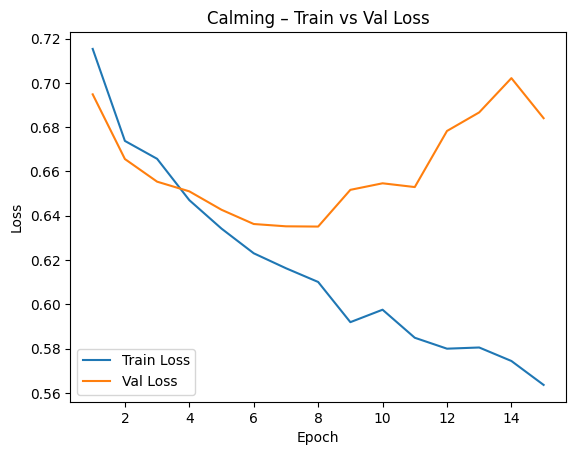

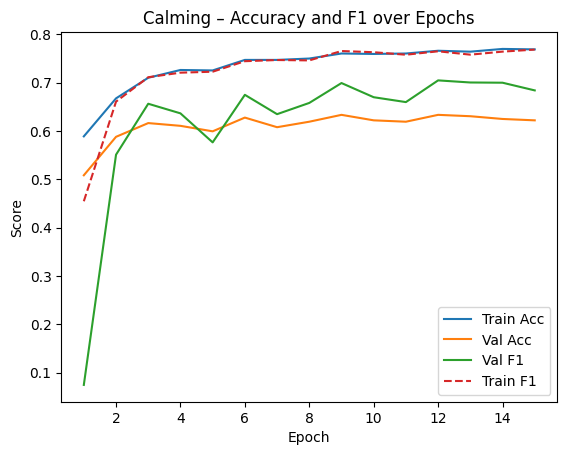

In [ ]:
# Train and evaluate the neural network model for calming condition
calm_model, calm_scaler, calm_history = train_and_evaluate(
    calm_X_train, calm_y_train,
    calm_X_valid, calm_y_valid,
    epochs=15
)

import matplotlib.pyplot as plt

epochs = calm_history["epoch"]

# 1. Loss: train vs val
plt.figure()
plt.plot(epochs, calm_history["train_loss"], label="Train Loss")
plt.plot(epochs, calm_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Calming – Train vs Val Loss")
plt.legend()
plt.show()

# 2. Accuracy + F1 (train & val)
plt.figure()
plt.plot(epochs, calm_history["train_acc"], label="Train Acc")
plt.plot(epochs, calm_history["val_acc"], label="Val Acc")
plt.plot(epochs, calm_history["val_f1"], label="Val F1")
plt.plot(epochs, calm_history["train_f1"], label="Train F1", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Calming – Accuracy and F1 over Epochs")
plt.legend()
plt.show()



#### Vexing

In [ ]:
MLPC_train_and_evaluate(vex_X_train, vex_X_valid, vex_X_test, vex_y_train, vex_y_valid, vex_y_test)

Feature scaling complete.
Training the Neural Network...
Training complete.

--- Neural Network Evaluation ---
Validation Accuracy: 44.32%


Training on cuda with 25 features.
Epoch  | TrLoss     | VaLoss     | TrAcc     | VaAcc     | VaF1     
--------------------------------------------------------------------------------


1      | 0.7059     | 0.6725     | 0.6165    | 0.5938    | 0.6898   


2      | 0.6651     | 0.6712     | 0.6638    | 0.5909    | 0.6923   


3      | 0.6531     | 0.6747     | 0.6771    | 0.5881    | 0.6934   


4      | 0.6328     | 0.6834     | 0.6989    | 0.6080    | 0.7076   


5      | 0.6177     | 0.7053     | 0.7102    | 0.5994    | 0.7019   


6      | 0.6221     | 0.6710     | 0.7112    | 0.6250    | 0.7040   


7      | 0.6054     | 0.6916     | 0.7254    | 0.6136    | 0.6991   


8      | 0.6032     | 0.7537     | 0.7188    | 0.5909    | 0.7000   


9      | 0.5812     | 0.7921     | 0.7273    | 0.5739    | 0.6939   


10     | 0.5840     | 0.7278     | 0.7320    | 0.5966    | 0.6992   


11     | 0.5886     | 0.7688     | 0.7348    | 0.5852    | 0.6946   


12     | 0.6055     | 0.7386     | 0.7377    | 0.5966    | 0.6966   


13     | 0.5789     | 0.6920     | 0.7377    | 0.6080    | 0.6714   


14     | 0.5839     | 0.7020     | 0.7415    | 0.5795    | 0.6425   


15     | 0.5841     | 0.7477     | 0.7396    | 0.5994    | 0.6941   


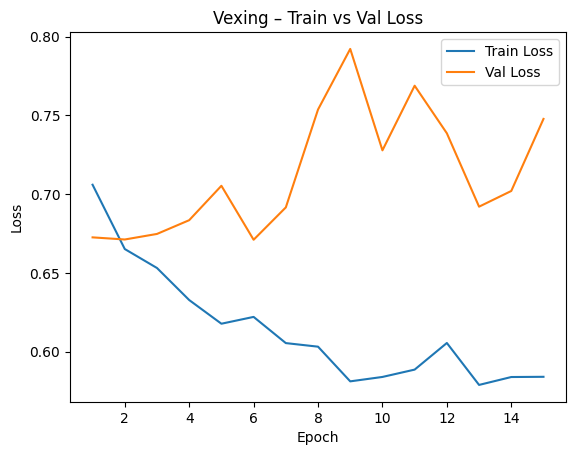

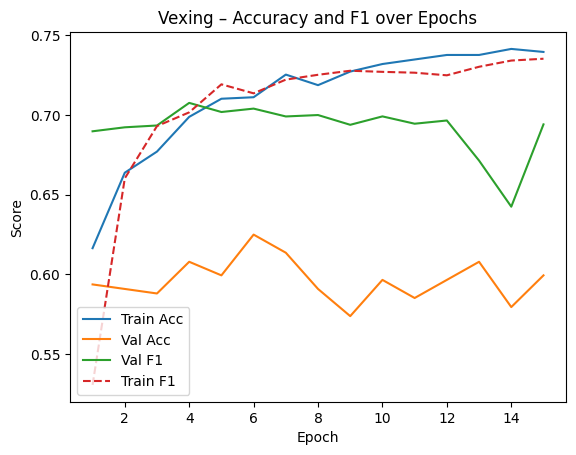

In [ ]:
# Train and evaluate the neural network model for vexing condition
vex_model, vex_scaler, vex_history = train_and_evaluate(
    vex_X_train, vex_y_train,
    vex_X_valid, vex_y_valid,
    epochs=15
)

import matplotlib.pyplot as plt

epochs = vex_history["epoch"]

# 1. Loss: train vs val
plt.figure()
plt.plot(epochs, vex_history["train_loss"], label="Train Loss")
plt.plot(epochs, vex_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Vexing – Train vs Val Loss")
plt.legend()
plt.show()

# 2. Accuracy + F1 (train & val)
plt.figure()
plt.plot(epochs, vex_history["train_acc"], label="Train Acc")
plt.plot(epochs, vex_history["val_acc"], label="Val Acc")
plt.plot(epochs, vex_history["val_f1"], label="Val F1")
plt.plot(epochs, vex_history["train_f1"], label="Train F1", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Vexing – Accuracy and F1 over Epochs")
plt.legend()
plt.show()

### Merge Vexing and Calming

In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# 1. Merge calming and vexing into one dataframe
full_df = pd.concat([calming_df, vexing_df], axis=0, ignore_index=True)
print("Full merged shape:", full_df.shape)

def split_merged_data(df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split merged (calming + vexing) data into train / val / test
    with no subject leakage using GroupShuffleSplit.

    final proportions ~ (1 - test_size - val_size, val_size, test_size)
    """
    # Remove any 'rest' if present
    df_filtered = df[df['n_back'] != 'rest'].copy()

    # Binary labels: 1 = one_back, 0 = three_back
    y = df_filtered['n_back'].map({'one_back': 1, 'three_back': 0})

    # Drop non-feature columns (keep only features for the model)
    cols_to_drop = ['n_back', 'subject_id', 'BlockNumber', 'TrialInBlock', 'task', 'music']
    X = df_filtered.drop(columns=cols_to_drop, errors='ignore')

    groups = df_filtered['subject_id']

    # ---- First split: train+val vs test ----
    gss1 = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=random_state)
    trainval_idx, test_idx = next(gss1.split(X, y, groups=groups))

    X_trainval, X_test = X.iloc[trainval_idx], X.iloc[test_idx]
    y_trainval, y_test = y.iloc[trainval_idx], y.iloc[test_idx]
    groups_trainval = groups.iloc[trainval_idx]

    # ---- Second split: train vs val within train+val ----
    # val_size is relative to the *whole* dataset, so convert to fraction of train+val
    val_frac_of_trainval = val_size / (1.0 - test_size)

    gss2 = GroupShuffleSplit(test_size=val_frac_of_trainval, n_splits=1, random_state=random_state)
    train_idx, val_idx = next(gss2.split(X_trainval, y_trainval, groups=groups_trainval))

    X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    print("Train size:", X_train.shape[0])
    print("Val size:  ", X_val.shape[0])
    print("Test size: ", X_test.shape[0])

    return X_train, X_val, X_test, y_train, y_val, y_test

# 2. Actually split
full_df = pd.get_dummies(full_df, columns=["condition"], drop_first=True)
full_X_train, full_X_valid, full_X_test, full_y_train, full_y_valid, full_y_test = split_merged_data(full_df)


Full merged shape: (3520, 32)
Train size: 2112
Val size:   704
Test size:  704


Training on cuda with 26 features.
Epoch  | TrLoss     | VaLoss     | TrAcc     | VaAcc     | VaF1     
--------------------------------------------------------------------------------


1      | 0.6783     | 0.6917     | 0.6359    | 0.5625    | 0.6702   


2      | 0.6621     | 0.6876     | 0.6757    | 0.5895    | 0.6756   


3      | 0.6474     | 0.6899     | 0.6795    | 0.5938    | 0.6905   


4      | 0.6409     | 0.6901     | 0.6832    | 0.5909    | 0.6923   


5      | 0.6322     | 0.6822     | 0.6965    | 0.6094    | 0.6975   


6      | 0.6232     | 0.6654     | 0.7088    | 0.6094    | 0.6934   


7      | 0.6171     | 0.6737     | 0.7173    | 0.6080    | 0.6885   


8      | 0.6150     | 0.6919     | 0.7244    | 0.6094    | 0.6981   


9      | 0.6131     | 0.6988     | 0.7188    | 0.6108    | 0.6962   


10     | 0.5991     | 0.7754     | 0.7292    | 0.5994    | 0.7025   


11     | 0.6053     | 0.7637     | 0.7377    | 0.5923    | 0.6944   


12     | 0.6005     | 0.8331     | 0.7282    | 0.5881    | 0.6992   


13     | 0.5996     | 0.8184     | 0.7382    | 0.5852    | 0.6958   


14     | 0.6024     | 0.8337     | 0.7353    | 0.5881    | 0.6998   


15     | 0.5907     | 0.8699     | 0.7429    | 0.5710    | 0.6937   


16     | 0.5845     | 0.8784     | 0.7453    | 0.5739    | 0.6939   


17     | 0.5758     | 0.9209     | 0.7472    | 0.5625    | 0.6908   


18     | 0.5827     | 0.9432     | 0.7571    | 0.5554    | 0.6879   


19     | 0.5828     | 0.9522     | 0.7434    | 0.5625    | 0.6914   


20     | 0.5778     | 0.9328     | 0.7528    | 0.5625    | 0.6914   


21     | 0.5793     | 0.8758     | 0.7557    | 0.5682    | 0.6929   


22     | 0.5672     | 1.0626     | 0.7585    | 0.5398    | 0.6824   


23     | 0.5672     | 1.0474     | 0.7680    | 0.5426    | 0.6837   


24     | 0.5688     | 1.0370     | 0.7628    | 0.5426    | 0.6837   


25     | 0.5624     | 1.1091     | 0.7614    | 0.5256    | 0.6757   


26     | 0.5616     | 0.9454     | 0.7685    | 0.5582    | 0.6874   


27     | 0.5494     | 1.1593     | 0.7723    | 0.5170    | 0.6731   


28     | 0.5659     | 1.3311     | 0.7680    | 0.5071    | 0.6692   


29     | 0.5614     | 1.1768     | 0.7765    | 0.5213    | 0.6744   


30     | 0.5569     | 1.2950     | 0.7760    | 0.5156    | 0.6724   


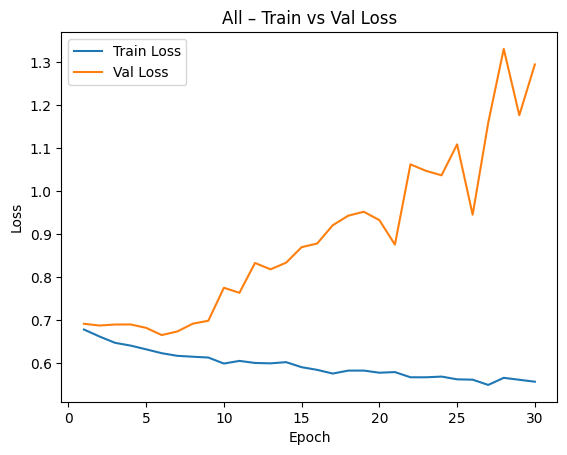

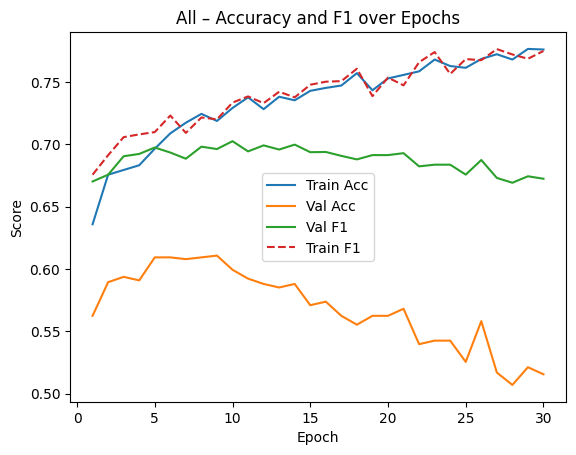

In [ ]:
full_model, full_scaler, full_history = train_and_evaluate(
    full_X_train, full_y_train,
    full_X_valid, full_y_valid,
    epochs=30
)
import matplotlib.pyplot as plt

epochs = full_history["epoch"]

# 1. Loss: train vs val
plt.figure()
plt.plot(epochs, full_history["train_loss"], label="Train Loss")
plt.plot(epochs, full_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("All – Train vs Val Loss")
plt.legend()
plt.show()

# 2. Accuracy + F1 (train & val)
plt.figure()
plt.plot(epochs, full_history["train_acc"], label="Train Acc")
plt.plot(epochs, full_history["val_acc"], label="Val Acc")
plt.plot(epochs, full_history["val_f1"], label="Val F1")
plt.plot(epochs, full_history["train_f1"], label="Train F1", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("All – Accuracy and F1 over Epochs")
plt.legend()
plt.show()

### Predicting Music Type

In [ ]:
### Here
# === Predicting music type instead of n_back ===
# 1. Merge calming + vexing trials
music_df = pd.concat([calming_df, vexing_df], axis=0, ignore_index=True)

# 2. Create binary target: 1 = Vexing, 0 = Calming
music_df["music_type"] = (music_df["condition"] == "Vexing").astype(int)

# 3. Build features and groups
df_filtered = music_df.copy()

y_music = df_filtered["music_type"]

# Drop label + IDs + other non-feature columns
cols_to_drop = [
    "music_type",      # label
    "condition",       # original string label
    "n_back",          # task label (we're not predicting this here)
    "subject_id",
    "BlockNumber",
    "TrialInBlock",
    "task",
    "music"
]
X_music = df_filtered.drop(columns=cols_to_drop, errors="ignore")

# Keep only numeric features (for scaler / models)
import numpy as np
X_music = X_music.select_dtypes(include=[np.number])

groups = df_filtered["subject_id"]

from sklearn.model_selection import GroupShuffleSplit

test_size = 0.20
val_size = 0.20

# ---- First split: train+val vs test ----
gss1 = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
trainval_idx, test_idx = next(gss1.split(X_music, y_music, groups=groups))

X_music_trainval, X_music_test = X_music.iloc[trainval_idx], X_music.iloc[test_idx]
y_music_trainval, y_music_test = y_music.iloc[trainval_idx], y_music.iloc[test_idx]
groups_trainval = groups.iloc[trainval_idx]

# ---- Second split: train vs val within train+val ----
val_frac_of_trainval = val_size / (1.0 - test_size)
gss2 = GroupShuffleSplit(test_size=val_frac_of_trainval, n_splits=1, random_state=42)
train_idx, val_idx = next(gss2.split(X_music_trainval, y_music_trainval, groups=groups_trainval))

X_music_train, X_music_val = X_music_trainval.iloc[train_idx], X_music_trainval.iloc[val_idx]
y_music_train, y_music_val = y_music_trainval.iloc[train_idx], y_music_trainval.iloc[val_idx]

print("Music target split:")
print("Train:", X_music_train.shape[0])
print("Val:  ", X_music_val.shape[0])
print("Test: ", X_music_test.shape[0])


Music target split:
Train: 2112
Val:   704
Test:  704


In [ ]:
music_model, music_scaler, music_history = train_and_evaluate(
    X_music_train, y_music_train,
    X_music_val, y_music_val,
    epochs=15
)


Training on cuda with 25 features.
Epoch  | TrLoss     | VaLoss     | TrAcc     | VaAcc     | VaF1     
--------------------------------------------------------------------------------


1      | 0.6495     | 0.7841     | 0.8196    | 0.5043    | 0.0224   


2      | 0.5521     | 1.3446     | 0.8769    | 0.5028    | 0.0113   


3      | 0.4664     | 1.6990     | 0.8991    | 0.5085    | 0.0389   


4      | 0.4035     | 2.0830     | 0.9223    | 0.5071    | 0.0334   


5      | 0.3703     | 2.7837     | 0.9323    | 0.5071    | 0.0334   


6      | 0.3311     | 2.9245     | 0.9366    | 0.5071    | 0.0334   


7      | 0.2903     | 3.0298     | 0.9474    | 0.5085    | 0.0389   


8      | 0.2701     | 3.3589     | 0.9579    | 0.5071    | 0.0334   


9      | 0.2723     | 3.7225     | 0.9631    | 0.5028    | 0.0169   


10     | 0.2330     | 3.6181     | 0.9598    | 0.5057    | 0.0279   


11     | 0.2343     | 3.6771     | 0.9692    | 0.5085    | 0.0389   


12     | 0.2237     | 3.0942     | 0.9754    | 0.5099    | 0.0443   


13     | 0.2029     | 3.0181     | 0.9754    | 0.5114    | 0.0497   


14     | 0.2055     | 3.0160     | 0.9806    | 0.5114    | 0.0497   


15     | 0.1861     | 3.5559     | 0.9792    | 0.5085    | 0.0389   


In [ ]:
knn_music_model, knn_music_grid = tune_and_eval_knn(
    X_music_train, y_music_train,
    X_music_val, y_music_val,
    X_music_test, y_music_test,
    k_values=[1, 3, 5, 7, 9, 11, 15],
    cv_folds=5,

)


Running grid search for KNN...

Best parameters: {'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best CV F1: 0.6940

=== Test Set Evaluation ===
              precision    recall  f1-score   support

           0     0.5731    0.7017    0.6309       352
           1     0.6154    0.4773    0.5376       352

    accuracy                         0.5895       704
   macro avg     0.5942    0.5895    0.5843       704
weighted avg     0.5942    0.5895    0.5843       704

Confusion matrix:
[[247 105]
 [184 168]]
